# Оценка качества синтетических изображений с помощью Fréchet Inception Distance (FID)

В этом ноутбуке мы сравним два набора изображений:
- `synthetic/` — синтетические изображения, сгенерированные в Blender;
- `real/` — реальные изображения с дронов (например, из датасета DroneDeploy).

**Методика**: используем предобученную сеть `InceptionV3` и библиотеку `torchmetrics` для вычисления FID.

📌 Убедитесь, что у вас установлены следующие библиотеки:
```bash
pip install torch torchvision torchmetrics matplotlib
```

📂 Структура папок (поместите изображения в эти директории):
```
FID_notebook.ipynb
├── synthetic/
│   ├── image001.png
│   └── ...
└── real/
    ├── image001.png
    └── ...
```

In [1]:
!pip install torch torchvision torchmetrics matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 51.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
!ls -lh /content/VisDrone2019-DET-val.zip

-rw-r--r-- 1 root root 23M May 17 15:53 /content/VisDrone2019-DET-val.zip


In [ ]:
import shutil
import os

def удалить_папку_и_содержимое(путь_к_папке):
  """Удаляет указанную папку и все ее содержимое.

  Args:
    путь_к_папке: Строка, представляющая путь к папке, которую нужно удалить.
  """
  try:
    if os.path.exists(путь_к_папке):
      shutil.rmtree(путь_к_папке)
      print(f"Папка '{путь_к_папке}' и все ее содержимое успешно удалены.")
    else:
      print(f"Ошибка: Папка '{путь_к_папке}' не существует.")
  except Exception as e:
    print(f"Произошла ошибка при удалении папки '{путь_к_папке}': {e}")

# Укажите путь к папке, которую вы хотите удалить
путь_к_удаляемой_папке = '/content/visdrone_val'  # Замените на фактический путь

# Вызовите функцию для удаления папки и ее содержимого
удалить_папку_и_содержимое(путь_к_удаляемой_папке)

Папка '/content/visdrone_val' и все ее содержимое успешно удалены.


Всего изображений: 174


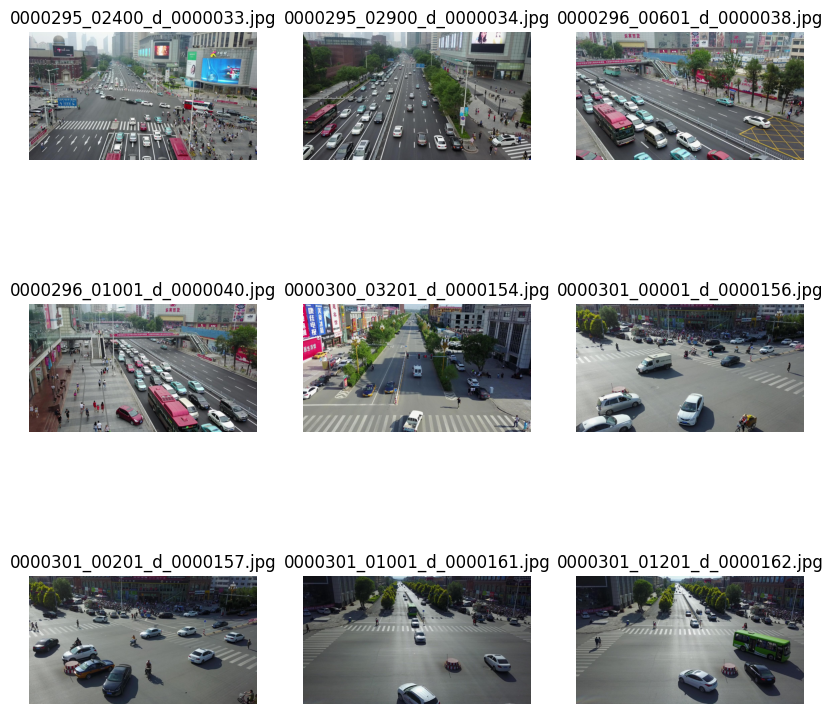

In [3]:
import os
import shutil
import zipfile
from PIL import Image
import matplotlib.pyplot as plt

# Распаковка архива
zip_path = '/content/VisDrone2019-DET-val.zip'
extract_path = '/content/real'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Создаём папку real
real_dir = '/content/real'
os.makedirs(real_dir, exist_ok=True)

# Путь до изображений внутри архива
images_path = os.path.join(extract_path, 'VisDrone2019-DET-val')

# Получим список всех изображений
all_images = sorted([f for f in os.listdir(images_path) if f.endswith('.jpg')])

print(f"Всего изображений: {len(all_images)}")

# Быстрый просмотр первых 9 кадров
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    img = Image.open(os.path.join(images_path, all_images[i]))
    ax.imshow(img)
    ax.set_title(all_images[i])
    ax.axis('off')
plt.show()


Найдено синтетических изображений: 11


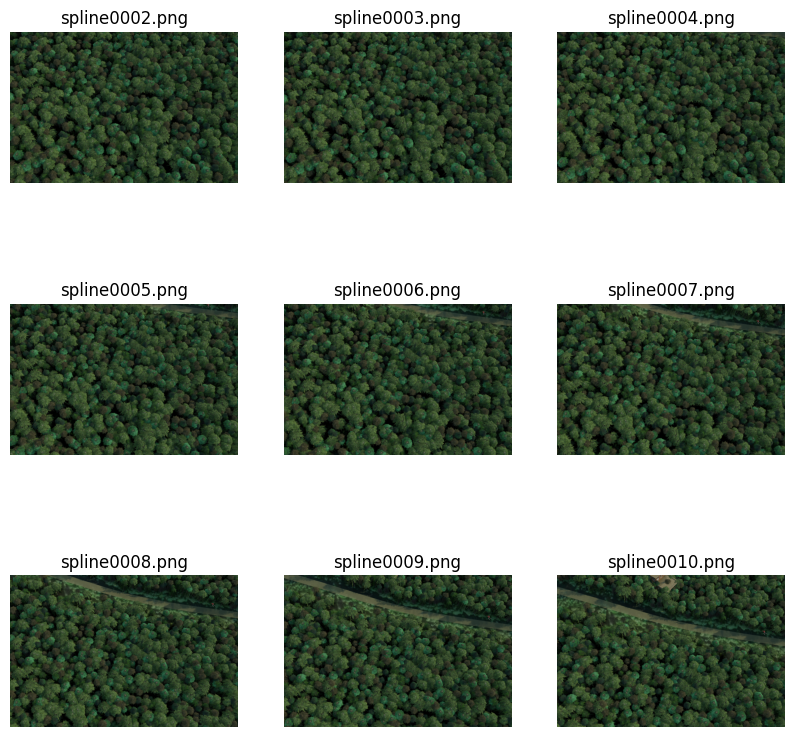

In [4]:
import os
import zipfile
import matplotlib.pyplot as plt
from PIL import Image

# Пути
zip_path = '/content/2.zip'
synthetic_dir = '/content/synthetic'

# Распаковка архива в synthetic/
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(synthetic_dir)

# Если в архиве была папка 2/, то продолжаем работать из неё
inner_folder = os.path.join(synthetic_dir, '2')
if os.path.isdir(inner_folder):
    synthetic_dir = inner_folder  # углубляемся

# Проверка содержимого
all_synth = sorted([f for f in os.listdir(synthetic_dir) if f.endswith(('.png', '.jpg'))])
print(f"Найдено синтетических изображений: {len(all_synth)}")

# Просмотр первых 9 изображений
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    img = Image.open(os.path.join(synthetic_dir, all_synth[i]))
    ax.imshow(img)
    ax.set_title(all_synth[i])
    ax.axis('off')
plt.show()

In [5]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchmetrics.image.fid import FrechetInceptionDistance
import torch

# Пути к папкам
synthetic_path = '/content/synthetic'
real_path = '/content/real'

# Устройство
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Размер, к которому приводим все изображения
image_size = (299, 299)

# Преобразования
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

def load_images_recursively(folder):
    """Рекурсивно загружает изображения из всех подкаталогов"""
    images = []
    for root, _, files in os.walk(folder):
        for filename in sorted(files):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(root, filename)
                img = Image.open(path).convert('RGB')
                img = transform(img)
                images.append(img)
    return torch.stack(images)

# Загрузка изображений
synthetic_images = load_images_recursively(synthetic_path)
real_images = load_images_recursively(real_path)

print(f'Синтетических изображений: {len(synthetic_images)}')
print(f'Реальных изображений: {len(real_images)}')


Синтетических изображений: 11
Реальных изображений: 174


In [9]:
!pip install torchmetrics[image]
!pip install torch-fidelity


In [13]:
import torch
from torch_fidelity import calculate_metrics

# Переводим изображения в uint8 [0..255] и сохраняем во временные папки
import os
import torchvision.transforms.functional as TF
import torchvision
from pathlib import Path
from PIL import Image

def save_tensor_images(images, folder):
    os.makedirs(folder, exist_ok=True)
    for i, img in enumerate(images):
        img_uint8 = (img * 255).byte()
        img_pil = TF.to_pil_image(img_uint8)
        img_pil.save(os.path.join(folder, f"{i:04}.png"))

# Временные папки
save_tensor_images(real_images, "real_temp")
save_tensor_images(synthetic_images, "synthetic_temp")

# Вычисляем FID
metrics = calculate_metrics(
    input1='real_temp',
    input2='synthetic_temp',
    cuda=torch.cuda.is_available(),
    isc=False,   # Inception Score — не нужен
    kid=False,   # Kernel Inception Distance — не нужен
    fid=True     # Только FID
)

print(f"FID: {metrics['frechet_inception_distance']:.2f}")


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "real_temp" with extensions png,jpg,jpeg
Found 174 samples
Processing samples
Extracting statistics from input 2
Looking for samples non-recursivelty in "synthetic_temp" with extensions png,jpg,jpeg
Found 11 samples
Processing samples


FID: 45.29


Frechet Inception Distance: 45.28615393246025


## 🎯 Интерпретация результата

FID = 0 — идеальное совпадение распределений признаков у синтетических и реальных изображений;
FID = 10–50 — хорошее сходство, применимо для обучения;
FID > 100 — сильный разрыв между синтетикой и реальностью.

Полученное значение FID показывает, насколько визуально и статистически синтетические изображения близки к реальным. Чем оно меньше — тем выше вероятность, что они подойдут для обучения нейросетей.